In [1]:
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
import os
os.chdir('C:/Users/kingsubham27091995/Desktop/AppliedAiCouse/CASE STUDIES/HumanActivityRecognition/HAR')

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [14]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\kingsubham27091995\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


## 1- Layer LSTM

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 41s 6ms/step - loss: 1.3306 - acc: 0.4361 - val_loss: 1.1743 - val_acc: 0.4723
Epoch 2/30
7352/7352 [==============================] - 40s 5ms/step - loss: 0.9716 - acc: 0.5788 - val_loss: 0.9656 - val_acc: 0.5263
Epoch 3/30
7352/7352 [==============================] - 40s 5ms/step - loss: 0.7787 - acc: 0.6510 - val_loss: 0.7841 - val_acc: 0.6135
Epoch 4/30
7352/7352 [==============================] - 40s 5ms/step - loss: 0.6911 - acc: 0.6587 - val_loss: 0.7109 - val_acc: 0.6203
Epoch 5/30
7352/7352 [==============================] - 41s 6ms/step - loss: 0.6496 - acc: 0.6794 - val_loss: 0.8000 - val_acc: 0.6362
Epoch 6/30
7352/7352 [==============================] - 44s 6ms/step - loss: 0.8295 - acc: 0.6221 - val_loss: 0.7970 - val_acc: 0.6318
Epoch 7/30
7352/7352 [==============================] - 41s 6ms/step - loss: 0.5920 - acc: 0.7

In [20]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  0      398        66        0                   0   
STANDING                 0      100       418        2                   0   
WALKING                  0        3         0      465                   8   
WALKING_DOWNSTAIRS       0        0         0        0                 360   
WALKING_UPSTAIRS         0        3         0       23                   1   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                           27  
STANDING                          12  
WALKING                           20  
WALKING_DOWNSTAIRS                60  
WALKING_UPSTAIRS                 444  


In [21]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 532us/step


In [22]:
score

[0.4692274864947224, 0.8805564981336953]

- With a simple 2 layer architecture we got 88.05% accuracy and a loss of 0.46
- We can further imporve the performace with Hyperparameter tuning

## Hyperparameter Tuning with different DropOut Rates keeping LSTM Units=32

In [29]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import LSTM

In [30]:
def build_model(units, rate):
    model = Sequential() # Initiliazing the sequential model
    model.add(LSTM(units=units, input_shape=(timesteps, input_dim))) # Configuring the parameters
    model.add(Dropout(rate=rate)) # Adding a dropout layer
    model.add(Dense(units=6, kernel_initializer='he_normal', activation='sigmoid')) # Adding a dense output layer with sigmoid activation
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) #Compiling the model
    #model.summary()
    return model

In [35]:
model = KerasClassifier(build_fn = build_model)
parameters = {'units': [32],
              'rate': [0.25, 0.5,0.7]
              }

In [39]:
grid_search_CV = GridSearchCV(estimator = model,
                           param_grid = parameters,
                           cv = 3,
                           n_jobs=4)
grid_search = grid_search_CV.fit(X_train, Y_train, epochs=30)

Epoch 1/30
7352/7352 [==============================] - 25s 3ms/step - loss: 1.3526 - acc: 0.4433
Epoch 2/30
7352/7352 [==============================] - 20s 3ms/step - loss: 1.0738 - acc: 0.5226
Epoch 3/30
7352/7352 [==============================] - 20s 3ms/step - loss: 1.0310 - acc: 0.5574
Epoch 4/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.8162 - acc: 0.6265
Epoch 5/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.7050 - acc: 0.6714
Epoch 6/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.6713 - acc: 0.7178
Epoch 7/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.6267 - acc: 0.7594
Epoch 8/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.5190 - acc: 0.8051
Epoch 9/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.4214 - acc: 0.8628
Epoch 10/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.3776 - acc: 0.8848
Epoch 11/30
7352/73

In [41]:
print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.900027 using {'rate': 0.25, 'units': 32}
0.900027 (0.011693) with: {'rate': 0.25, 'units': 32}
0.803047 (0.064273) with: {'rate': 0.5, 'units': 32}
0.787677 (0.059909) with: {'rate': 0.7, 'units': 32}


## After hyperparameter tuning :
1. Accuracy=90%
1. DropOut Rate=0.25(Best)
1. LSTM Units= 32

## Defining few Functions

> __Plotting Confusion Matrix__

In [42]:
# Plot Confusion Matrix
def plot_confusion_matrix_lstm(y_test, y_predict):
    result = confusion_matrix(y_test, y_predict)

    plt.figure(figsize=(12, 10))
    sns.heatmap(result, 
                xticklabels= list(ACTIVITIES.values()), 
                yticklabels=list(ACTIVITIES.values()), 
                annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

> __Plotting epochs vs Loss __

In [43]:
# Plot train and cross validation loss
def plot_train_cv_loss(trained_model, epochs, colors=['b']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,epochs+1))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'b', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw() 

## 2- Layer LSTM's

In [46]:
# Initializing parameters
n_epochs = 30
n_batch = 16
n_classes = _count_classes(Y_train)

# Bias regularizer value - we will use elasticnet
# https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/
from keras.regularizers import L1L2
reg = L1L2(0.01, 0.01)

> __LSTM units=32  , Dropout= 0.50__

In [51]:
from keras.layers import LSTM , BatchNormalization
from keras.layers.core import Dense, Dropout
# Model execution
model = Sequential()
model.add(LSTM(32, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(32))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
# Training the model
trained_model  = model.fit(X_train,
                           Y_train,
                           batch_size=n_batch,
                           validation_data=(X_test, Y_test),
                           epochs=epochs)

Model Summary: 
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 91s 12ms/step - loss: 1.5640 - acc: 0.5994 - val_loss: 1.1322 - val_acc: 0.6695
Epoch 2/30
7352/7352 [==============================] - 86s 12ms/step - loss: 0.9878 - acc: 0.7040 - val_loss: 0.7904 - val_acc: 0.7323
Epoch 3/30
7352/7352 [==============================] - 84s 11ms/step - loss: 0.6829 - acc: 0.7848 - val_loss: 0.5545 - val_acc: 0.7788
Epoch 4/30
7352/7352 [==============================] - 91s 12ms/step - loss: 0.4845 - acc: 0.8428 - val_loss: 0.4397 - val_acc: 0.8602
Epoch 5/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.3833 - acc: 0.8862 - val_loss: 0.4002 - val_acc: 0.8599
Epoch 6/30
7352/7352 [==============================] - 85s 12ms/step - loss: 0.3076 - acc: 0.9115 - val_loss: 0.2842 - val_acc: 0.8985
Epoch 7/30
7352/7352 [==============================] - 88s 12ms/step - loss: 0.2519 - acc: 0.9261 - val_loss: 1.0203 - 

### Plotting Epochs vs Loss

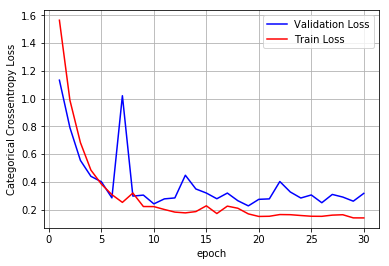

In [54]:
% matplotlib inline
import matplotlib.pyplot as plt

# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)

__From epoch 10, we starts to overfit the model, so best value for epoch is 10__

### Plotting Confusion Matrix

Test Accuracy: 90.498812%


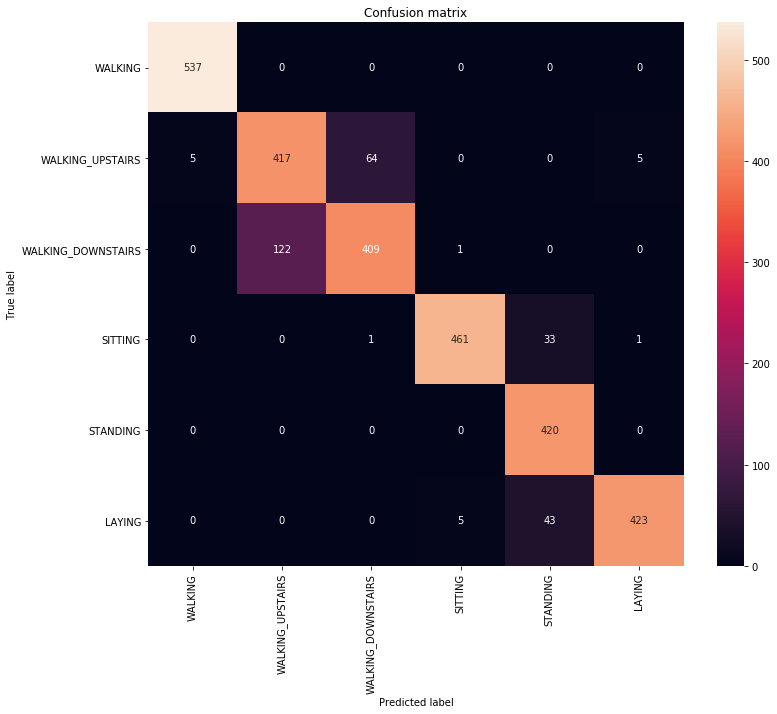

In [61]:
import seaborn as sns

scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: %f%%" % (scores[1]*100))

Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Confusion Matrix
plot_confusion_matrix_lstm(Y_true, Y_predictions)

> __LSTM Units= 32 , DropOut= 0.25__

In [62]:
from keras.layers import LSTM , BatchNormalization
from keras.layers.core import Dense, Dropout
# Model execution
model = Sequential()
model.add(LSTM(32, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(LSTM(32))
model.add(Dropout(0.25))
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
# Training the model
trained_model  = model.fit(X_train,
                           Y_train,
                           batch_size=n_batch,
                           validation_data=(X_test, Y_test),
                           epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 85s 12ms/step - loss: 1.4139 - acc: 0.6511 - val_loss: 1.0345 - val_acc: 0.7733
Epoch 2/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.6820 - acc: 0.8478 - val_loss: 0.9108 - val_acc: 0.7353
Epoch 3/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.3863 - acc: 0.9063 - val_loss: 0.7907 - val_acc: 0.7251
Epoch 4/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.2706 - acc: 0.9234 - val_loss: 0.4915 - val_acc: 0.8409
Epoch 5/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.2132 - acc: 0.9317 - val_loss: 0.2458 - val_acc: 0.9108
Epoch 6/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.2573 - acc: 0.9195 - val_loss: 0.3387 - val_acc: 0.8778
Epoch 7/30
7352/7352 [==============================] - 82s 11ms/step - loss: 0.2000 - acc: 0.9347 - val_loss: 0.3301 - val_acc: 0.8785


### Plotting epochs vs Loss

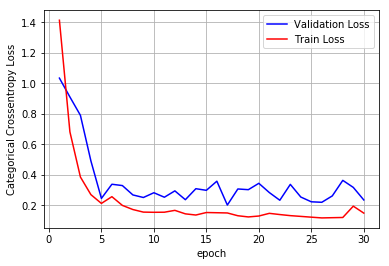

In [63]:
# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)

### Plotting Confusion Matrix

Test Accuracy: 91.482864%


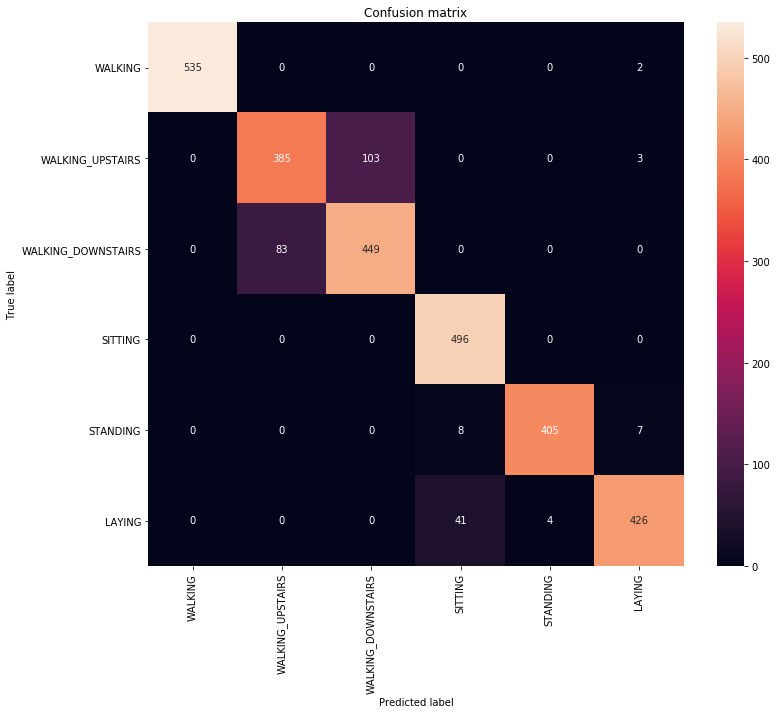

In [64]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: %f%%" % (scores[1]*100))
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Confusion Matrix
plot_confusion_matrix_lstm(Y_true, Y_predictions)

> __LSTM Units= 64,  Dropout =0.50__

In [65]:
# Model execution
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True, bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(50))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
# Training the model
trained_model  = model.fit(X_train,
                           Y_train,
                           batch_size=n_batch,
                           validation_data=(X_test, Y_test),
                           epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 135s 18ms/step - loss: 1.8012 - acc: 0.6477 - val_loss: 1.3358 - val_acc: 0.6956
Epoch 2/30
7352/7352 [==============================] - 109s 15ms/step - loss: 0.8502 - acc: 0.8311 - val_loss: 0.5815 - val_acc: 0.8833
Epoch 3/30
7352/7352 [==============================] - 106s 14ms/step - loss: 0.3816 - acc: 0.9064 - val_loss: 0.3977 - val_acc: 0.8778
Epoch 4/30
7352/7352 [==============================] - 105s 14ms/step - loss: 0.2546 - acc: 0.9170 - val_loss: 0.2446 - val_acc: 0.9138
Epoch 5/30
7352/7352 [==============================] - 106s 14ms/step - loss: 0.2292 - acc: 0.9223 - val_loss: 0.5429 - val_acc: 0.8578
Epoch 6/30
7352/7352 [==============================] - 109s 15ms/step - loss: 0.2293 - acc: 0.9212 - val_loss: 0.2791 - val_acc: 0.8989
Epoch 7/30
7352/7352 [==============================] - 128s 17ms/step - loss: 0.1958 - acc: 0.9300 - val_loss: 0.3770 - val_acc: 

### Plotting Epochs vs Loss

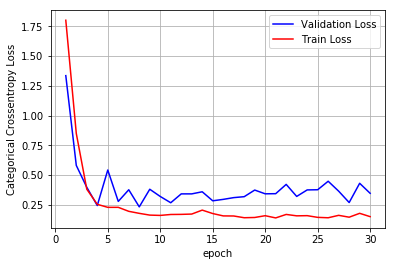

In [66]:
# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)

__From epoch 8, we starts to overfit the model, so best value for epoch is 8__

### Plotting Confusion Matrix

Test Accuracy: 91.279267%


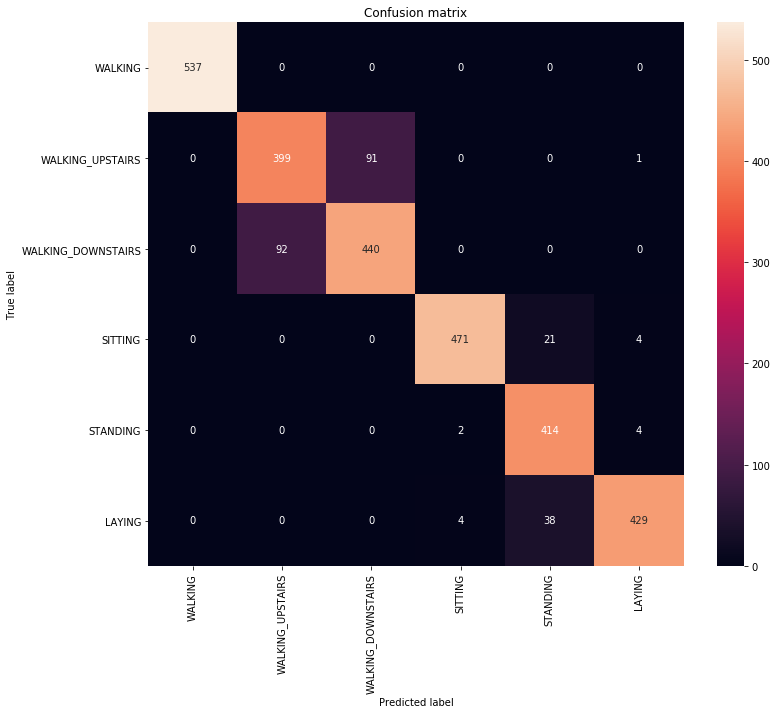

In [67]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: %f%%" % (scores[1]*100))
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Confusion Matrix
plot_confusion_matrix_lstm(Y_true, Y_predictions)

## Let's try by increasing the Dropout Rate to 0.7

> __LSTM Units= 32, Dropout =0.7__

In [68]:
# Model execution
model = Sequential()
model.add(LSTM(32, input_shape=(timesteps, input_dim), return_sequences=True, bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.70))
model.add(LSTM(32))
model.add(Dropout(0.70))
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
# Training the model
trained_model  = model.fit(X_train,
                           Y_train,
                           batch_size=n_batch,
                           validation_data=(X_test, Y_test),
                           epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 102s 14ms/step - loss: 1.7457 - acc: 0.5113 - val_loss: 1.5490 - val_acc: 0.5439
Epoch 2/30
7352/7352 [==============================] - 90s 12ms/step - loss: 1.1467 - acc: 0.5977 - val_loss: 0.8771 - val_acc: 0.6759
Epoch 3/30
7352/7352 [==============================] - 97s 13ms/step - loss: 0.8728 - acc: 0.6338 - val_loss: 0.7650 - val_acc: 0.6793
Epoch 4/30
7352/7352 [==============================] - 90s 12ms/step - loss: 0.7970 - acc: 0.6375 - val_loss: 0.7806 - val_acc: 0.6861
Epoch 5/30
7352/7352 [==============================] - 101s 14ms/step - loss: 0.7615 - acc: 0.6462 - val_loss: 0.7199 - val_acc: 0.6162
Epoch 6/30
7352/7352 [==============================] - 86s 12ms/step - loss: 0.7379 - acc: 0.6513 - val_loss: 0.6871 - val_acc: 0.6695
Epoch 7/30
7352/7352 [==============================] - 85s 12ms/step - loss: 0.7141 - acc: 0.6759 - val_loss: 0.6486 - val_acc: 0.664

### Plotting epochs vs Loss

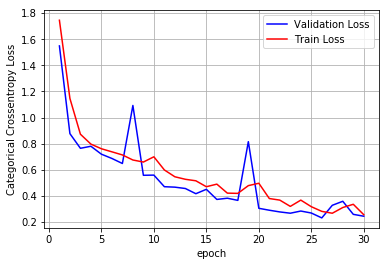

In [69]:
# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)

__From epoch 9, we starts to overfit the model, so best value for epoch is 9__

### Plotting Confusion Matrix

Test Accuracy: 91.720394%


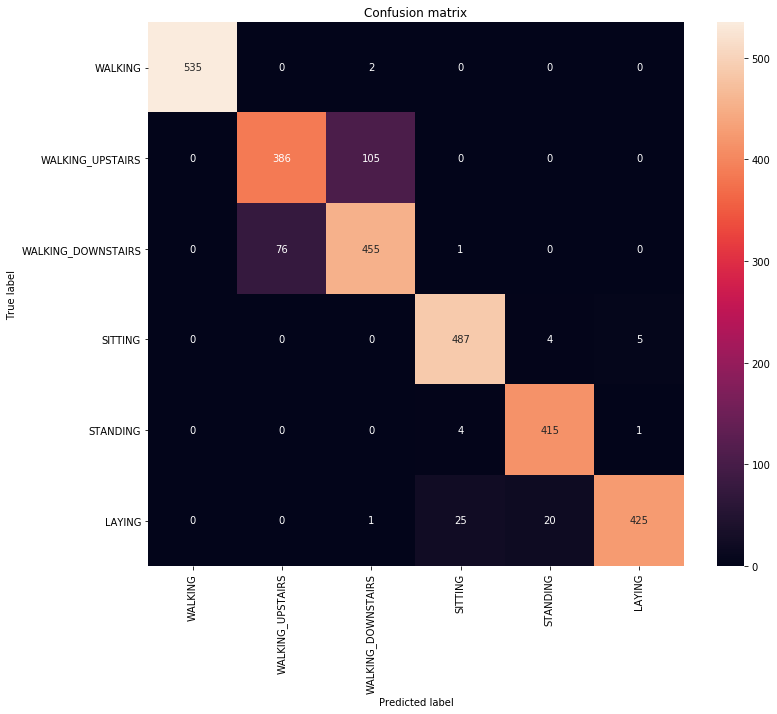

In [70]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: %f%%" % (scores[1]*100))

Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Confusion Matrix
plot_confusion_matrix_lstm(Y_true, Y_predictions)

> __LSTM Units = 64 with Dropout= 0.7__

In [71]:
# Model execution
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True, bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.70))
model.add(LSTM(50))
model.add(Dropout(0.70))
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])
# Training the model
trained_model  = model.fit(X_train,
                           Y_train,
                           batch_size=n_batch,
                           validation_data=(X_test, Y_test),
                           epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 113s 15ms/step - loss: 2.0342 - acc: 0.5740 - val_loss: 1.4051 - val_acc: 0.6586
Epoch 2/30
7352/7352 [==============================] - 106s 14ms/step - loss: 1.1879 - acc: 0.6488 - val_loss: 0.8965 - val_acc: 0.7048
Epoch 3/30
7352/7352 [==============================] - 119s 16ms/step - loss: 0.8405 - acc: 0.6725 - val_loss: 0.6462 - val_acc: 0.7543
Epoch 4/30
7352/7352 [==============================] - 113s 15ms/step - loss: 0.6449 - acc: 0.7360 - val_loss: 0.5011 - val_acc: 0.8107
Epoch 5/30
7352/7352 [==============================] - 108s 15ms/step - loss: 0.5405 - acc: 0.8112 - val_loss: 0.4277 - val_acc: 0.8429
Epoch 6/30
7352/7352 [==============================] - 122s 17ms/step - loss: 0.4521 - acc: 0.8570 - val_loss: 0.6293 - val_acc: 0.7587
Epoch 7/30
7352/7352 [==============================] - 124s 17ms/step - loss: 0.4124 - acc: 0.8770 - val_loss: 0.3884 - val_acc: 

### Plotting epochs vs Loss

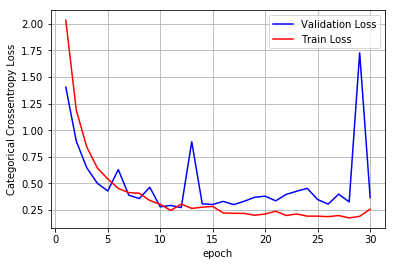

In [72]:
# Plot train and cross validation error
plot_train_cv_loss(trained_model, epochs)

### Plotting Confusion Matrix

In [ ]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: %f%%" % (scores[1]*100))
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(Y_test), axis=1)])

# Confusion Matrix
plot_confusion_matrix_lstm(Y_true, Y_predictions)

## Pretty Table

In [ ]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ["LSTM Layers",'LSTM Units','Dropout', 'Test Accuracy']
ptable.add_row(["1","32","0.50","88%"])
ptable.add_row(["1","32","0.25","90%"])
ptable.add_row(["2","32","0.50","90.49%"])
ptable.add_row(["2","32","0.25","91.48%"])
ptable.add_row(["2","64","0.50","91.28%"])
ptable.add_row(["2","32","0.70","91.72%"])
ptable.add_row(["2","64","0.70","89.68"])
print(ptable)

## Conclusion:
1. It is very easy to Overfit in LSTM, since the number of datapoints is small and No. of Parameters is Large. So, we can't train much complex networks.
1. To prevent Overfiting we use the DropOut Layer. We checked using different DropOut Rates, to make out model perform well.
1. The best Accuracy=91.72% which is produced when we gave LSTM Units=32, LSTM Layers=2, DropOut rate=0.70. 
1. Tuning the Hyperparameter is very important to get better results.
1. Deep Learning Models performed fairly well, but Feature engineered ML Models gave better accuracy.